# Analyzing PBMC scATAC-seq

In this notebook, we will analyze PBMC scATAC-seq data. scATAC-seq data is similar to scRNA-seq data. scRNA data tells us how expressible certain genes are for each cell, whereas scATAC data tells us how accessible DNA regions are for transcription. 

Following [vignette](https://stuartlab.org/signac/articles/pbmc_vignette) by Stuartlab and a [Youtube video](https://www.youtube.com/watch?v=yEKZJVjc5DY&t=1033s) by bioinfomagician.

This cell is useful for configuring plot size in Jupyter Notebook.

In [ ]:
library(repr)
options(repr.plot.width=16, repr.plot.height=8)

## Preparation

Here are the data we will use. Data can be obtained by either using `wget` command or from the [vignette](https://stuartlab.org/signac/articles/pbmc_vignette).

``` 
wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5
wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_singlecell.csv
wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz
wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz.tbi
```

We can save all the files in `'../data/atac'` after downloading.

In [1]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             

In [2]:
list.files(path = '../data/atac')

[1] "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5"
[2] "atac_v1_pbmc_10k_fragments.tsv.gz"          
[3] "atac_v1_pbmc_10k_fragments.tsv.gz.tbi"      
[4] "atac_v1_pbmc_10k_singlecell.csv"

Install packages if needed.

In [3]:
# remotes::install_github("stuart-lab/signac", ref="develop")
# install.packages("Matrix", type = "source")
# install.packages("irlba", type = "source")
# BiocManager::install("EnsDb.Hsapiens.v75")

ERROR: Error in loadNamespace(name): there is no package called ‘remotes’


In [3]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v75)
library(tidyverse)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading re

## Look at the data

This is what frag file looks like.

In [4]:
frag.file <- read.delim('../data/atac/atac_v1_pbmc_10k_fragments.tsv.gz', header = F, nrows = 10)
head(frag.file)

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<int>
1,chr1,10066,10279,TTAGCTTAGGAGAACA-1,2
2,chr1,10072,10279,TTAGCTTAGGAGAACA-1,2
3,chr1,10079,10316,ATATTCCTCTTGTACT-1,2
4,chr1,10084,10340,CGTACAAGTTACCCAA-1,1
5,chr1,10085,10271,TGTGACAGTACAACGG-1,1
6,chr1,10085,10339,CATGCCTTCTCTGACC-1,1


There are five columns in this data. Here is a quick overview on each column:

    - First column: Reference genome used to identify chromosome.
    - Second: Starting position of the fragment.
    - Third: End position of the fragment.
    - Fourth: Barcode fragment, which is used to identify sample. Same as `CB` tag in BAM file.
    - Fifth: Total number of reads associated with this fragment.
    
More information about fragment data can be found on https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/fragments.

Let's take a look at this now. If you get an error saying `Error in Read10X_h5("../data/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5"): Please install hdf5r to read HDF5 files`, install `libhdf5-dev` using 

`sudo apt-get install libhdf5-dev` (using terminal on debian/ubuntu)

and 

`install.packages('hdf5r')` on R.

You can also install it using github and devtool:
``` R
install.packages('devtools')
devtools::install_github("hhoeflin/hdf5r")
```

If you are using anaconda, you have to install `hdfr5` on conda using `mamba install hdf5` then install `hdf5r` on R.

In [6]:
# install.packages('devtools')
# devtools::install_github("hhoeflin/hdf5r")

In [5]:
counts <- Read10X_h5('../data/atac/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5')
counts[1:10,1:10]

  [[ suppressing 10 column names 'AAACGAAAGAGCGAAA-1', 'AAACGAAAGAGTTTGA-1', 'AAACGAAAGCGAGCTA-1' ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                      
chr1:565107-565550 . . . . . . . . . .
chr1:569174-569639 . . . . . . . . . .
chr1:713460-714823 . . 2 8 . . 2 2 . .
chr1:752422-753038 . . . . . . . . . .
chr1:762106-763359 . . 4 2 . . . . 2 .
chr1:779589-780271 . . . . . . . . . .
chr1:793516-793741 . . . 1 . . . . . .
chr1:801120-801338 . . . . . . . . . .
chr1:804872-805761 . . . 4 . . . . . .
chr1:839520-841123 . . 2 2 . . . . . .

The first number is the range of open chromatin. Dots mean zeros. Numbers after the range represent `tn5` integration site in each cell that maps to the region. `tn5` is an enzyme that binds to open chromatin region. Learn more about `tn5`: https://www.youtube.com/watch?v=uuxpyhGNDsk. 

`chrom_assay` has many information in it.

In [6]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  fragments = "../data/atac/atac_v1_pbmc_10k_fragments.tsv.gz",
  min.cells = 10,
  min.features = 200
)

str(chrom_assay)

Computing hash



Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 24 levels "chr1","chr2",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. .. .. ..@ lengths        : int [1:24] 8555 6858 5499 3515 4389 5269 4263 3677 3540 4137 ...
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:87561] 565107 569174 713460 752422 762106 779589 793516 801120 804872 839520 ...
  .. .. .. .. ..@ width          : int [1:87561] 444 466 1364 617 1254 683 226 219 890 1604 ...
  .. .. .. .. ..@ NAMES          : NULL
  .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ strand

In [7]:
metadata <- read.csv(file = '../data/atac/atac_v1_pbmc_10k_singlecell.csv', header = T, row.names = 1)
View(metadata)

,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,cell_id,is__cell_barcode,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NO_BARCODE,8335327,3922818,71559,746476,634014,22972,2937488,None,0,0,0,0,0,0,0,0
AAACGAAAGAAACGCC-1,3,1,0,1,0,0,1,None,0,1,1,1,0,1,0,1
AAACGAAAGAAAGCAG-1,14,1,0,4,2,0,7,None,0,0,2,0,0,2,0,0
AAACGAAAGAAAGGGT-1,7,1,0,1,0,0,5,None,0,2,2,0,1,2,0,1
AAACGAAAGAAATACC-1,9880,5380,79,106,1120,6,3189,None,0,386,1623,297,107,1758,16,262
AAACGAAAGAAATCTG-1,2,0,0,0,0,0,2,None,0,1,2,1,1,2,0,2
AAACGAAAGAAATGGG-1,4,2,0,1,0,0,1,None,0,0,1,1,0,1,0,1
AAACGAAAGAAATTCG-1,2,0,0,0,1,0,1,None,0,0,0,0,0,0,0,0
AAACGAAAGAACCATA-1,12,3,0,8,0,0,1,None,0,0,1,0,0,1,0,0


In [8]:
pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  meta.data = metadata,
  assay = 'ATAC'
)

In [9]:
str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ ATAC:Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  .. .. .. ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. .. ..@ values         : Factor w/ 24 levels "chr1","chr2",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. .. .. .. .. .. ..@ lengths        : int [1:24] 8555 6858 5499 3515 4389 5269 4263 3677 3540 4137 ...
  .. .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. .. .. .. ..@ start          : int [1:87561] 565107 569174 713460 752422 762106 779589 793516 801120 804872 839520 ...
  .. .. .. .. .. .. .. ..@ width          : int [1:87561] 444 466 1364 617 1254 683 226 219 890 1604 ...


We want to store annotations into pbmc Serat object.

In [10]:
pbmc@assays$ATAC@annotation

NULL

When we look at the `annotations`, we see that they are not compatible with 10x genomics pbmc data we have. We need to add `chr` in front of each seqnames column. This is because the data was mapped to `hg19`.

In [11]:
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [12]:
annotations

GRanges object with 3072120 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430        X 192989-193061      + | ENST00000399012      PLCXD1
  ENSE00001536003        X 192991-193061      + | ENST00000484611      PLCXD1
  ENSE00002160563        X 193020-193061      + | ENST00000430923      PLCXD1
  ENSE00001750899        X 197722-197788      + | ENST00000445062      PLCXD1
  ENSE00001489388        X 197859-198351      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739       MT     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789       MT   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851       MT     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899       MT     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

Add the gene information to the object.

In [13]:
# change to UCSC style since the data was mapped to hg19
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg19"

In [14]:
Annotation(pbmc) <- annotations
pbmc@assays$ATAC@annotation

GRanges object with 3072120 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 192989-193061      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 192991-193061      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 193020-193061      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 197722-197788      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 197859-198351      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739    chrMT     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789    chrMT   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851    chrMT     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899    chrMT     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

## Compute Quality Control

As with scRNA, 

Compute nucleosome signal score per cell

In [15]:
pbmc <- NucleosomeSignal(pbmc)

Compute TSS enrichment score per cell

In [16]:
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



Add blacklist ratio and fraction of reads in peaks

In [17]:
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100

In [18]:
View(pbmc@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,⋯,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,blacklist_ratio,pct_reads_in_peaks
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACGAAAGAGCGAAA-1,SeuratProject,13187,5546,22965,10872,183,198,1198,51,10463,⋯,3249,8894,6,6796,1.0654206,0.71,4.640020,0.21,0.0008828723,64.952690
AAACGAAAGAGTTTGA-1,SeuratProject,16069,6581,21806,9336,122,175,1050,1,11122,⋯,3600,10034,10,8319,0.7808219,0.12,4.453305,0.13,0.0012020676,74.797698
AAACGAAAGCGAGCTA-1,SeuratProject,28008,9213,46233,21197,479,292,2673,14,21578,⋯,8763,18562,22,14333,1.0098131,0.61,5.404080,0.63,0.0015349194,66.424136
AAACGAAAGGCTTCGC-1,SeuratProject,221734,30313,288897,99998,2830,1512,16347,913,167297,⋯,70515,144918,300,113658,1.1167315,0.77,5.099342,0.45,0.0026394974,67.937859
AAACGAAAGTGCTGAG-1,SeuratProject,11439,4921,16103,6751,104,120,867,0,8261,⋯,2987,7288,4,5879,0.9705882,0.54,5.301675,0.57,0.0006803878,71.165718
AAACGAACAAGGGTAC-1,SeuratProject,12696,5076,266481,45654,3425,1514,41940,57,173891,⋯,1686,85168,2121,7360,1.5340344,0.95,1.315511,0.00,0.2881793478,4.232536
AAACGAAGTCAGGCTC-1,SeuratProject,6306,2690,10753,4760,61,43,644,96,5149,⋯,2289,4183,8,3220,1.3441397,0.91,4.830786,0.30,0.0024844720,62.536415
AAACGAAGTGCCCGAT-1,SeuratProject,21980,8817,31745,14341,167,191,1465,29,15552,⋯,4911,14115,23,11399,0.9137022,0.41,4.440355,0.13,0.0020177209,73.296039
AAACGAAGTTGTATCG-1,SeuratProject,15862,6644,23136,10210,145,157,1308,15,11301,⋯,4019,10072,8,8215,1.0715686,0.71,4.367917,0.11,0.0009738284,72.692682


## Visualizing Quality Control

In [19]:
colnames(pbmc@meta.data)

[1] "orig.ident"                       "nCount_ATAC"                     
 [3] "nFeature_ATAC"                    "total"                           
 [5] "duplicate"                        "chimeric"                        
 [7] "unmapped"                         "lowmapq"                         
 [9] "mitochondrial"                    "passed_filters"                  
[11] "cell_id"                          "is__cell_barcode"                
[13] "TSS_fragments"                    "DNase_sensitive_region_fragments"
[15] "enhancer_region_fragments"        "promoter_region_fragments"       
[17] "on_target_fragments"              "blacklist_region_fragments"      
[19] "peak_region_fragments"            "nucleosome_signal"               
[21] "nucleosome_percentile"            "TSS.enrichment"                  
[23] "TSS.percentile"                   "blacklist_ratio"                 
[25] "pct_reads_in_peaks"

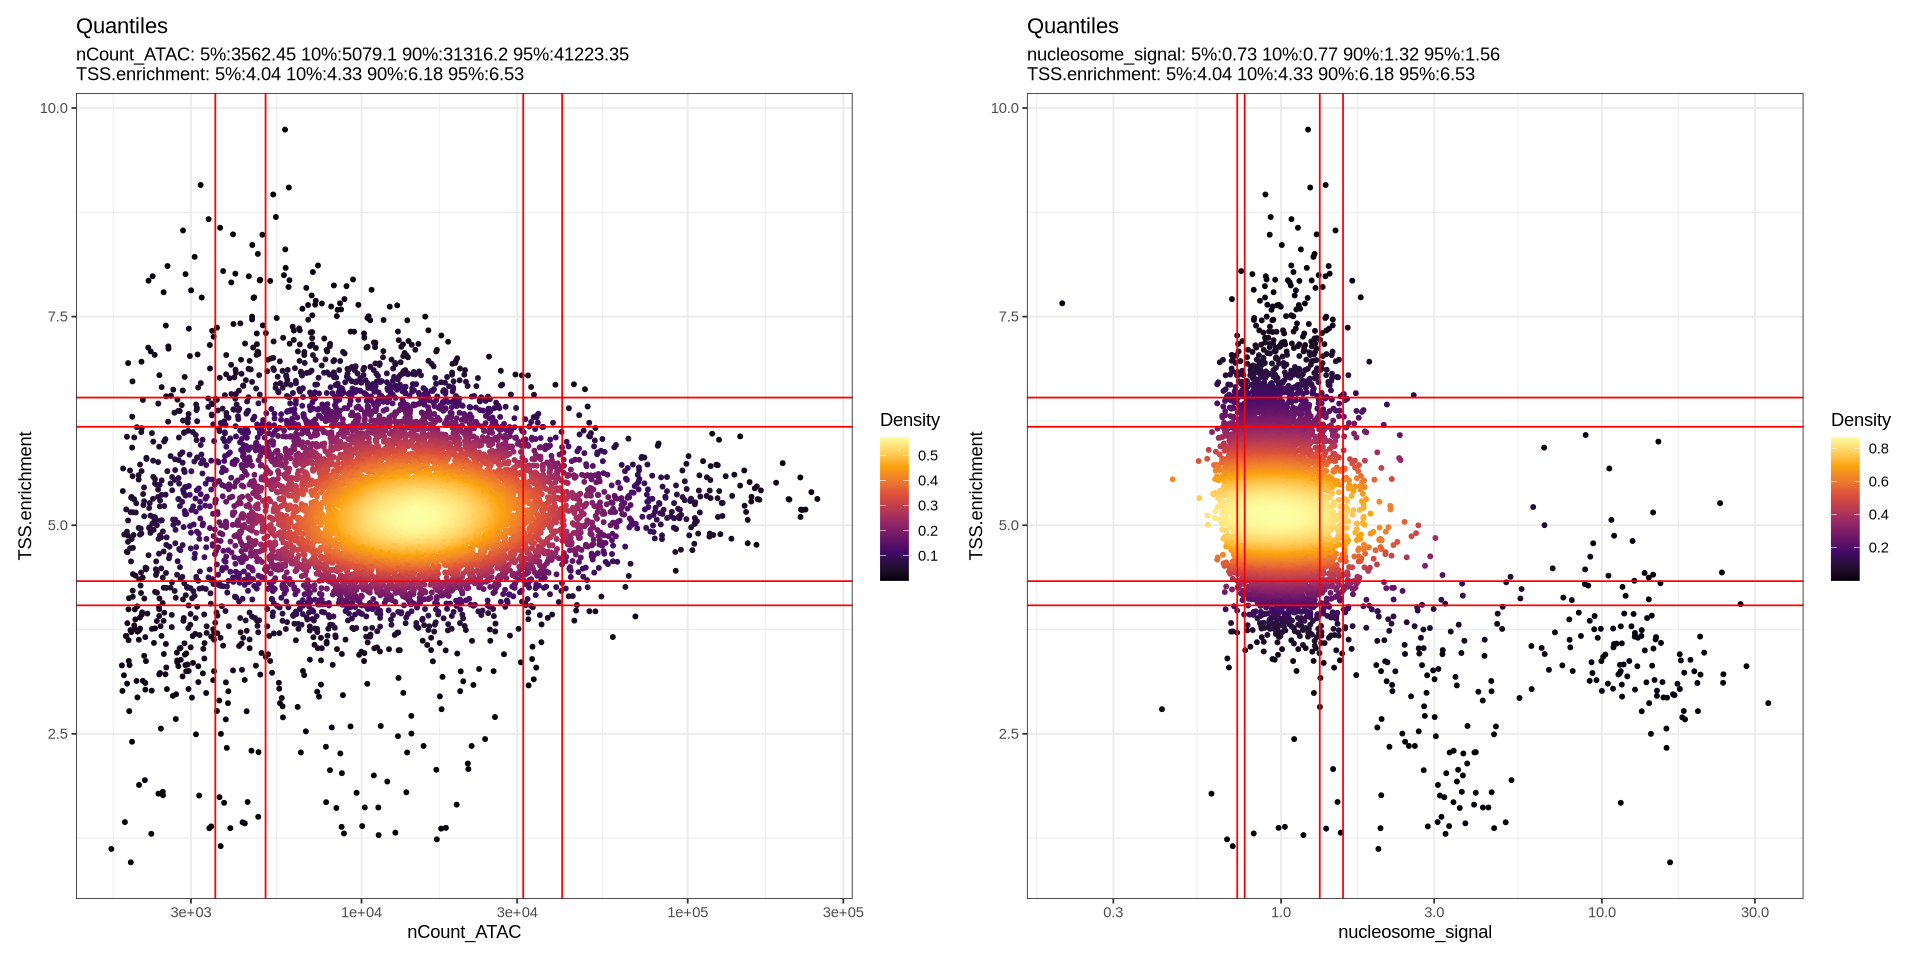

In [32]:
a1 <- DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)
a2 <- DensityScatter(pbmc, x = 'nucleosome_signal', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

a1 | a2

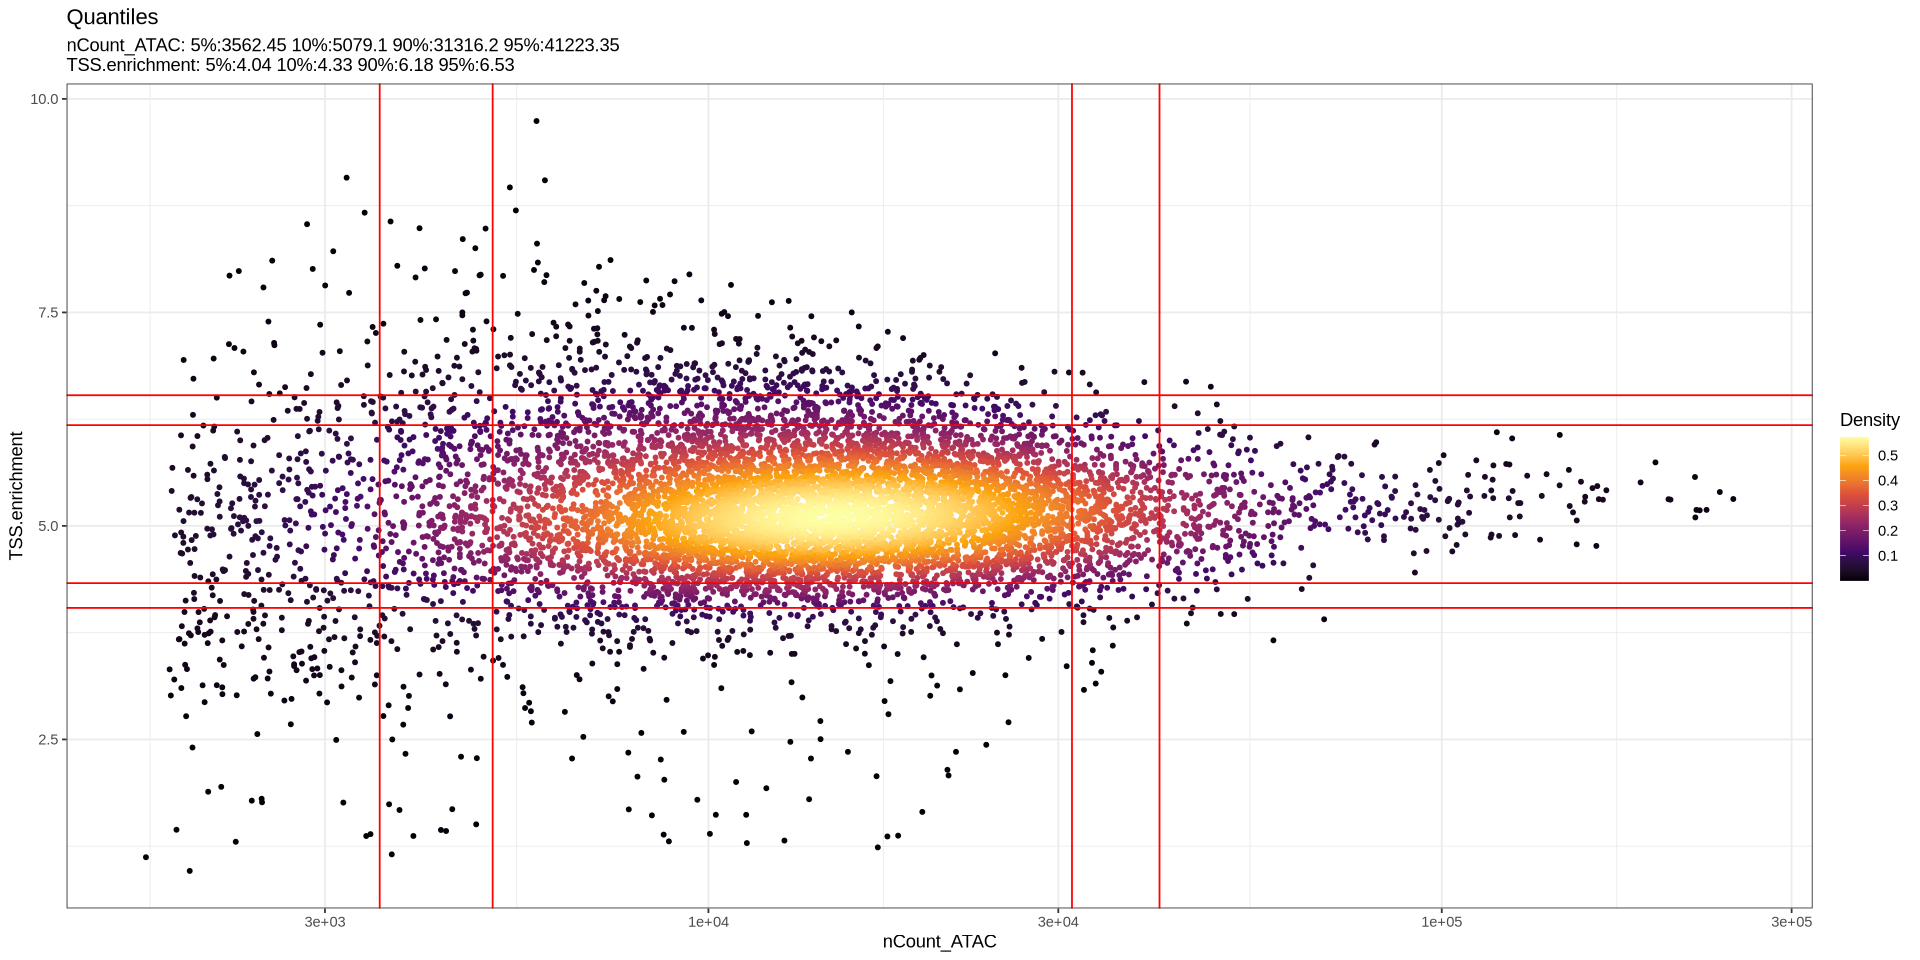

In [33]:
a1

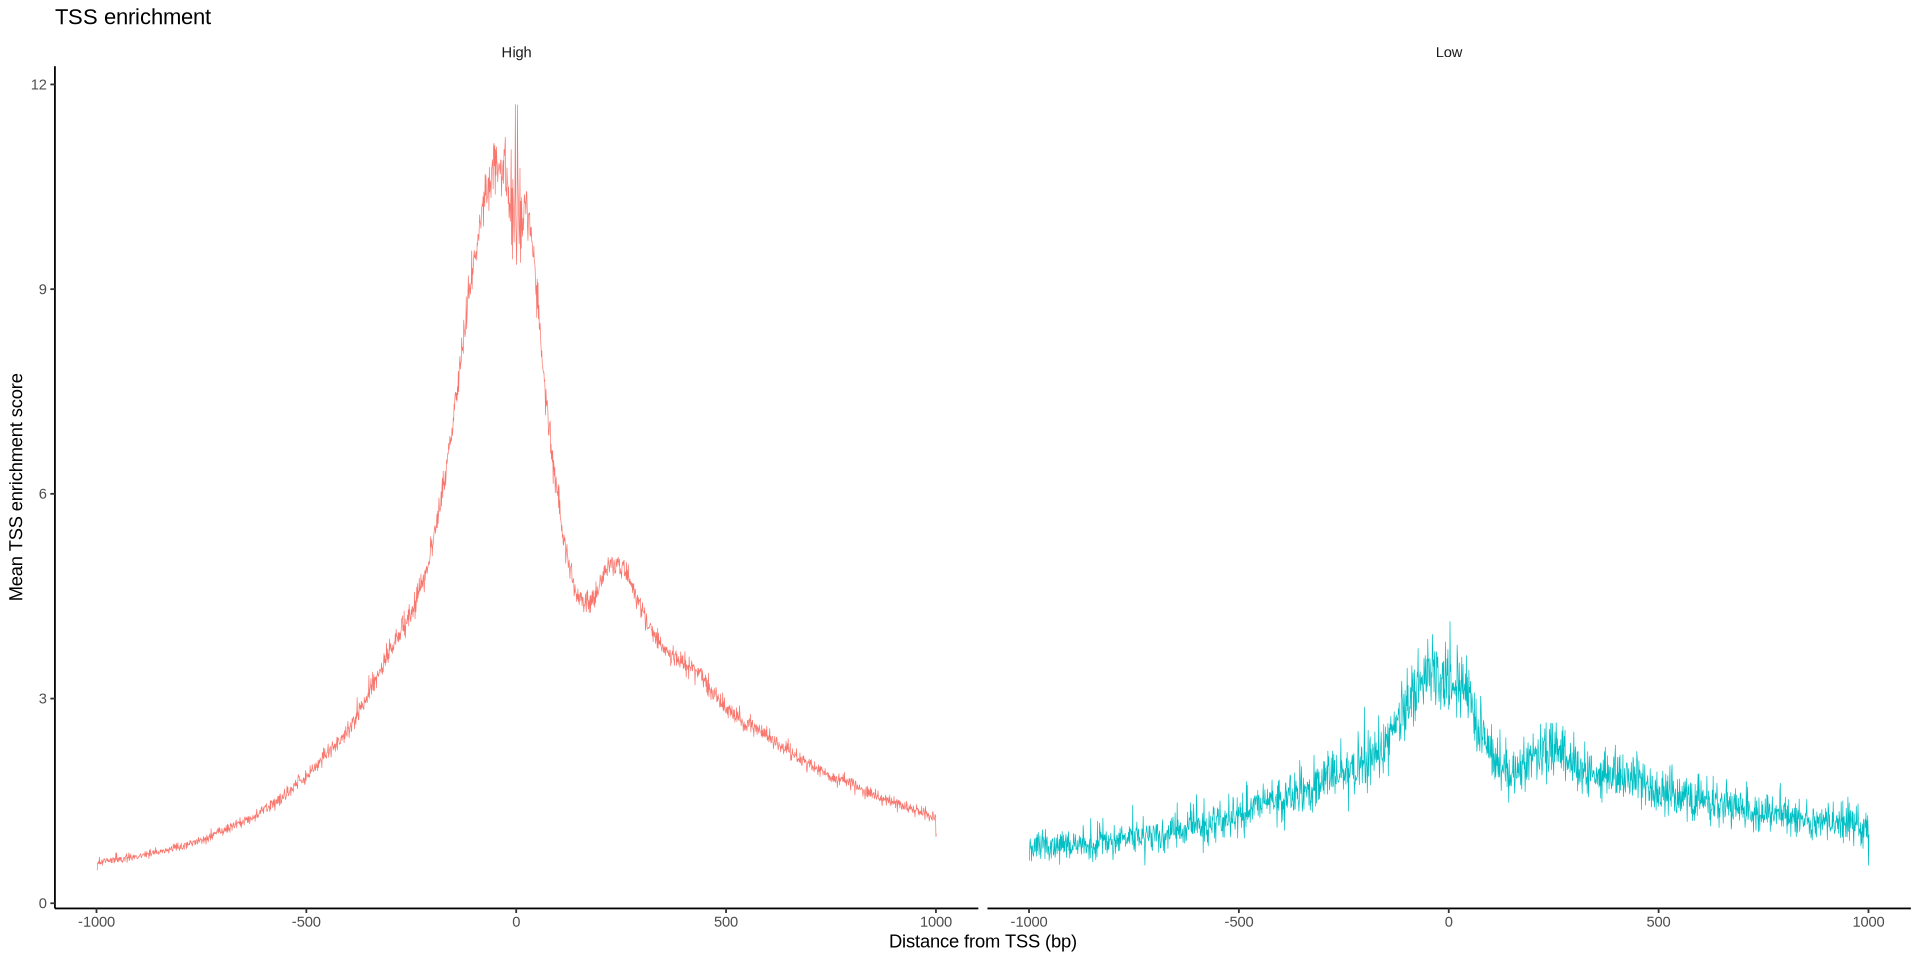

In [34]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + NoLegend()

Warning message:
"Removed 92 rows containing non-finite outside the scale range
(`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale
range (`geom_bar()`)."


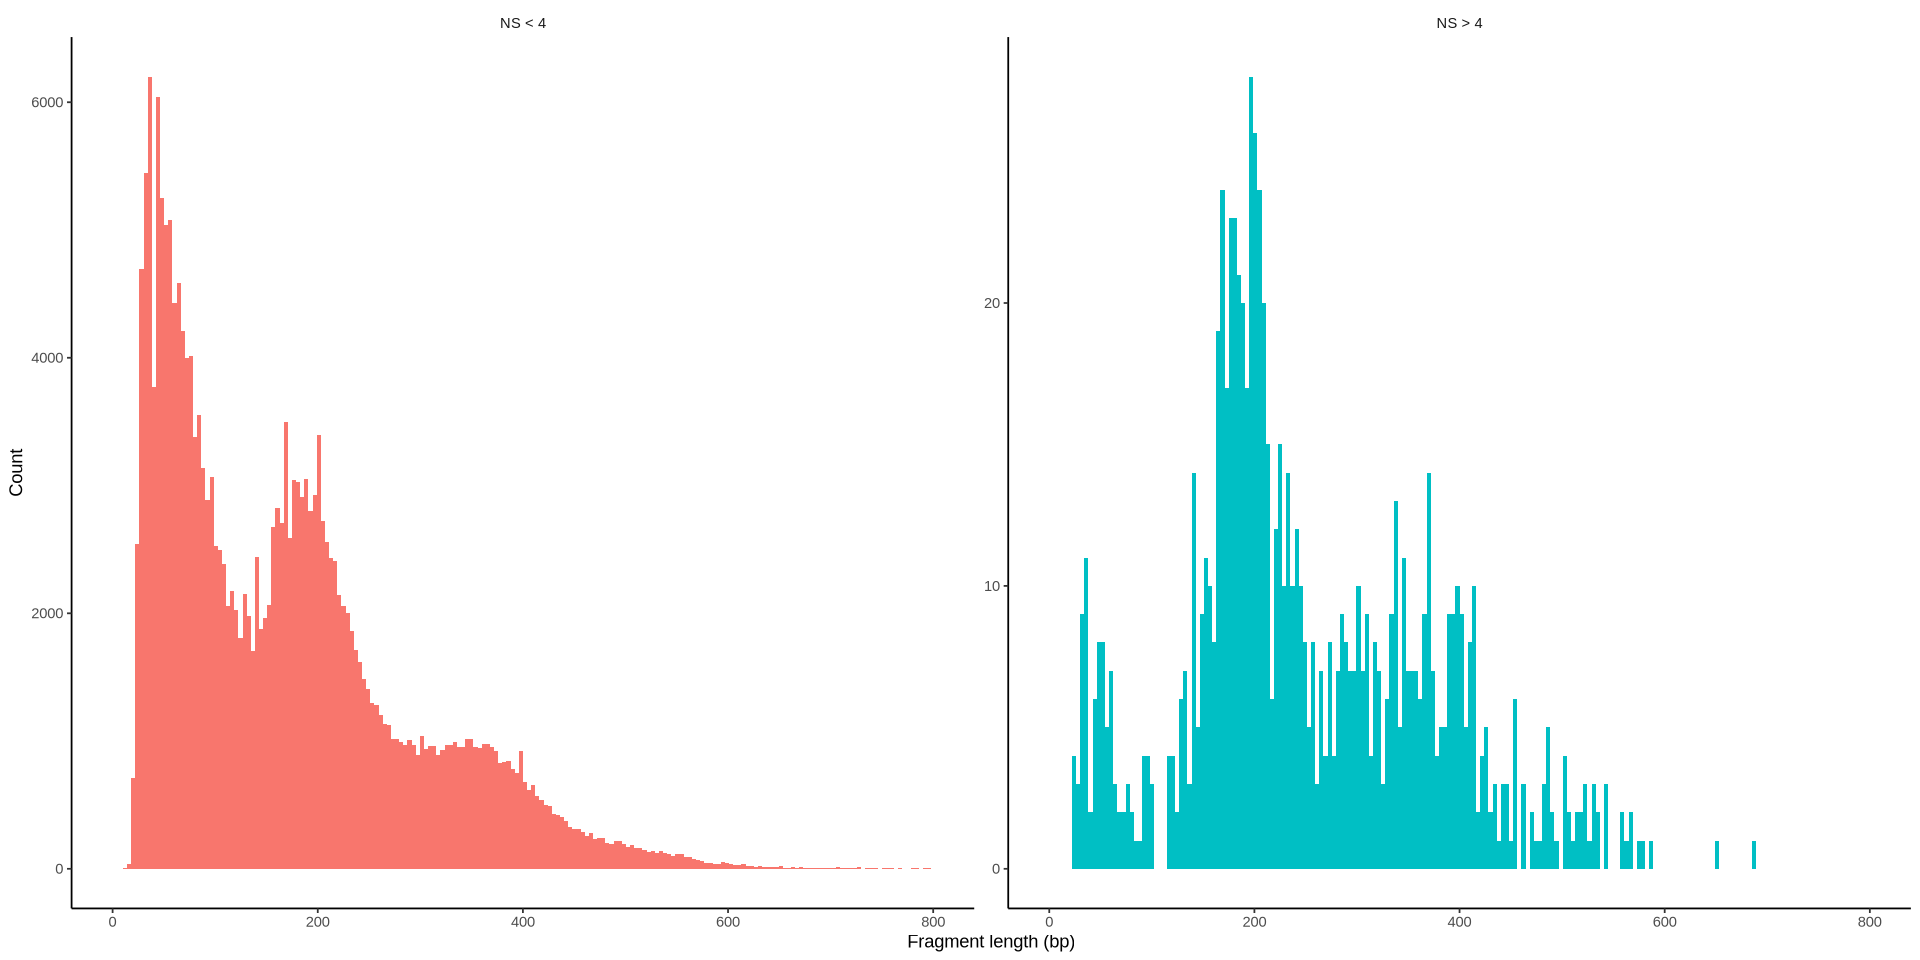

In [31]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

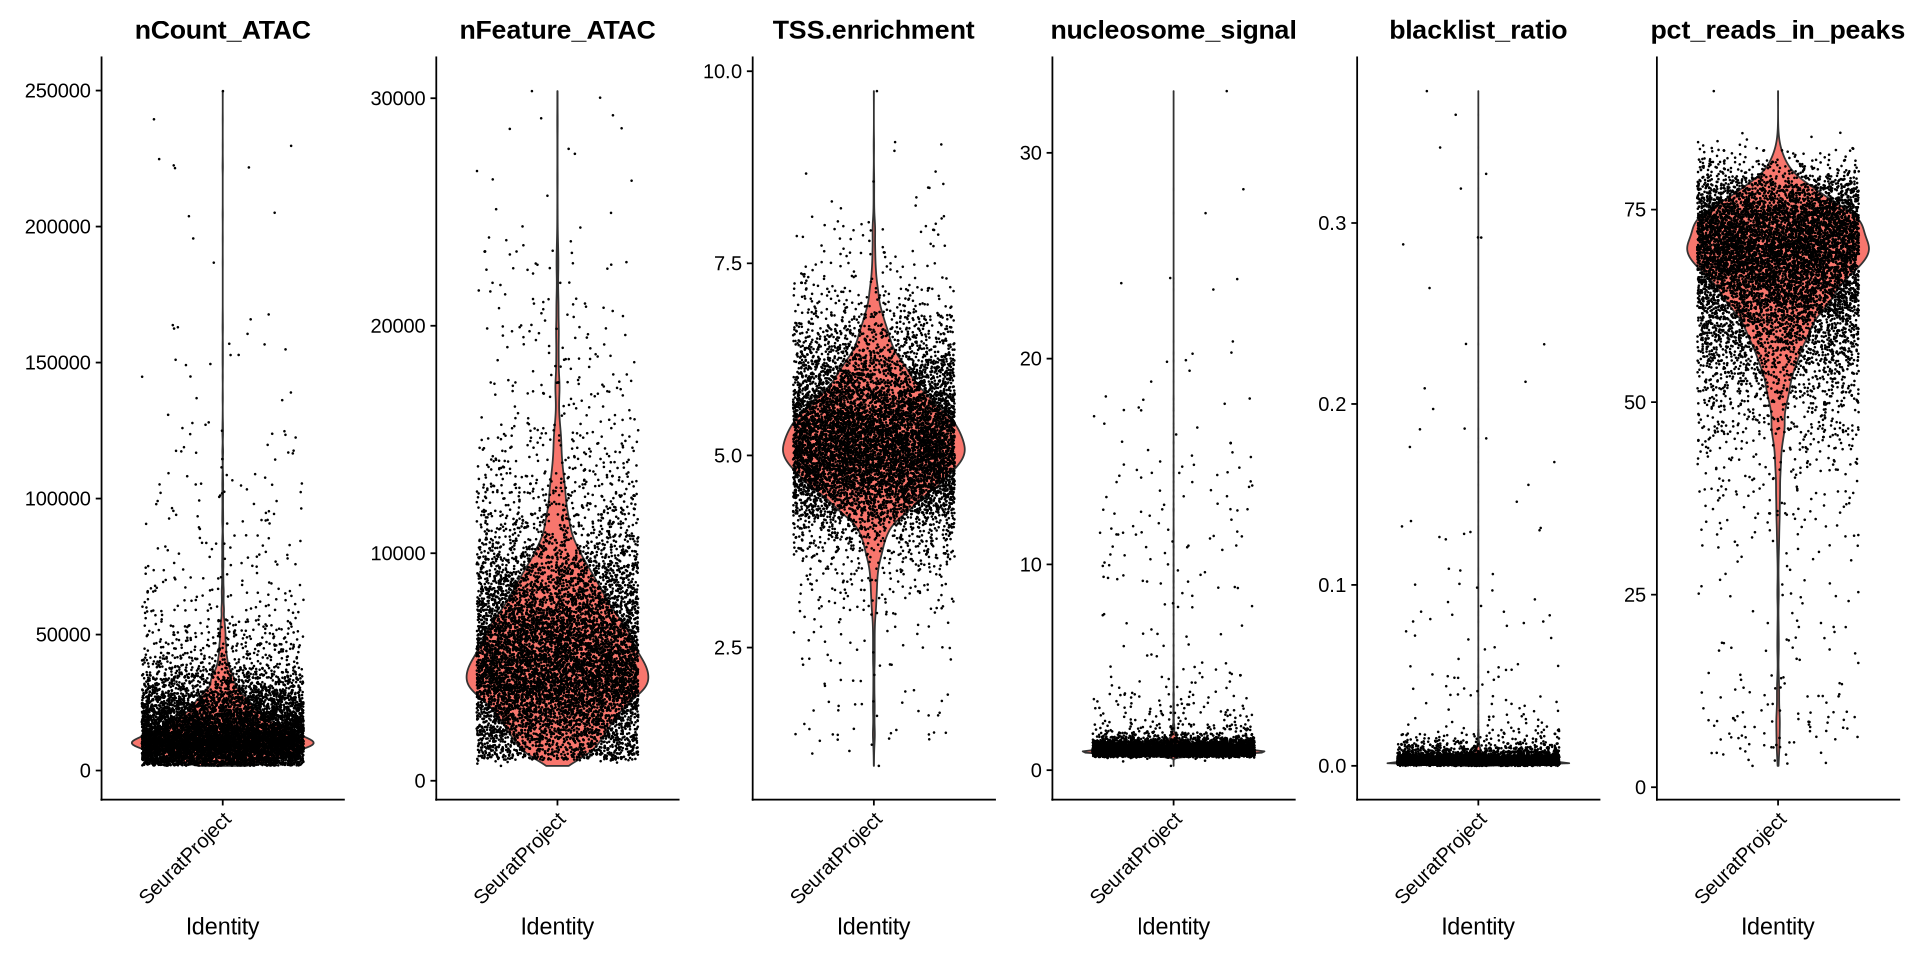

In [30]:
VlnPlot(object = pbmc, 
        features = c('nCount_ATAC', 'nFeature_ATAC', 'TSS.enrichment', 'nucleosome_signal', 'blacklist_ratio', 'pct_reads_in_peaks'),
        pt.size = 0.1,
        ncol = 6)

## Filtering poor quality cells

In [35]:
pbmc <- subset(x = pbmc,
               subset = nCount_ATAC > 3000 &
                 nCount_ATAC < 30000 &
                 pct_reads_in_peaks > 15 & 
                 blacklist_ratio < 0.05 &
                 nucleosome_signal < 4 &
                 TSS.enrichment > 3)

## Normalization and linear dimensional reduction

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



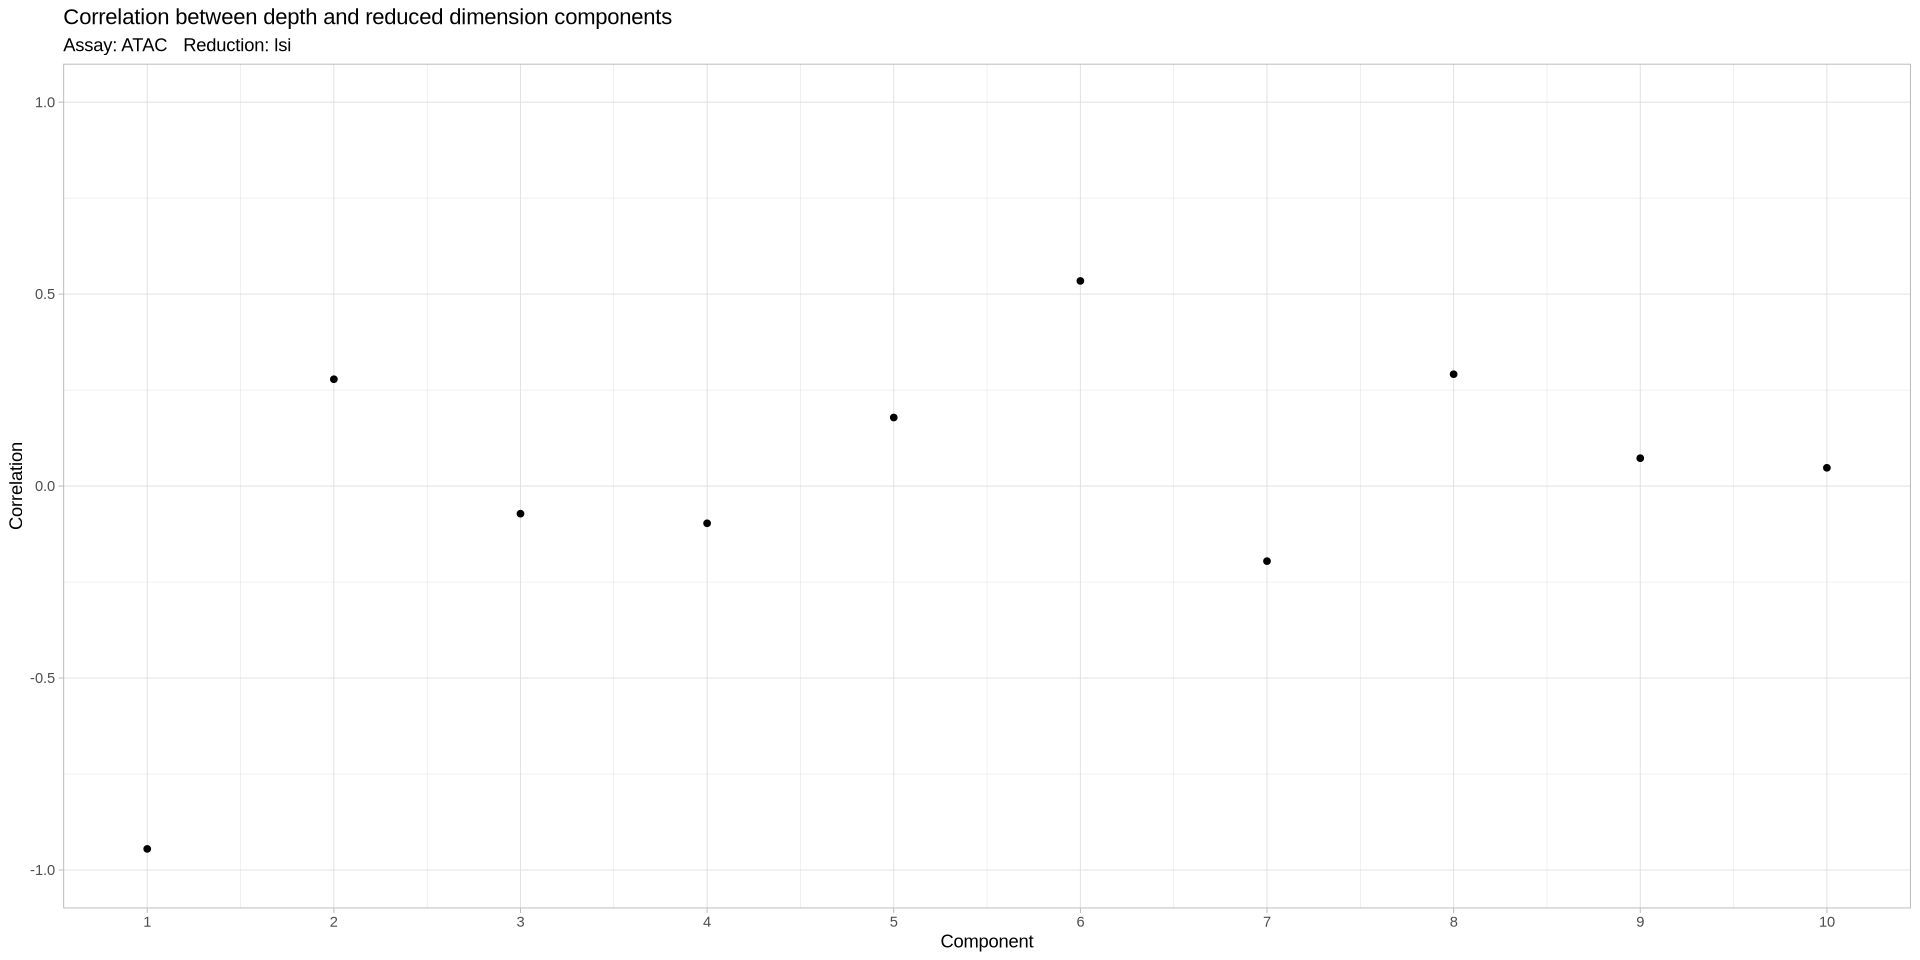

In [36]:
pbmc <- RunTFIDF(pbmc) # normalization
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0') # selecting top features
pbmc <- RunSVD(pbmc) # dimensionality reduction

DepthCor(pbmc)

## Non-linear dimensional reduction and Clustering

17:38:28 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

17:38:28 Read 7307 rows and found 29 numeric columns

17:38:28 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

17:38:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:38:28 Writing NN index file to temp file /tmp/RtmpvjIqFH/filec3e2677a9ca

17:38:28 Searching Annoy index using 1 thread, search_k = 3000

17:38:30 Annoy recall = 100%

17:38:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:38:33 Initializing from normalized Laplacian + no

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7307
Number of edges: 258970

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8542
Number of communities: 17
Elapsed time: 2 seconds


1 singletons identified. 16 final clusters.



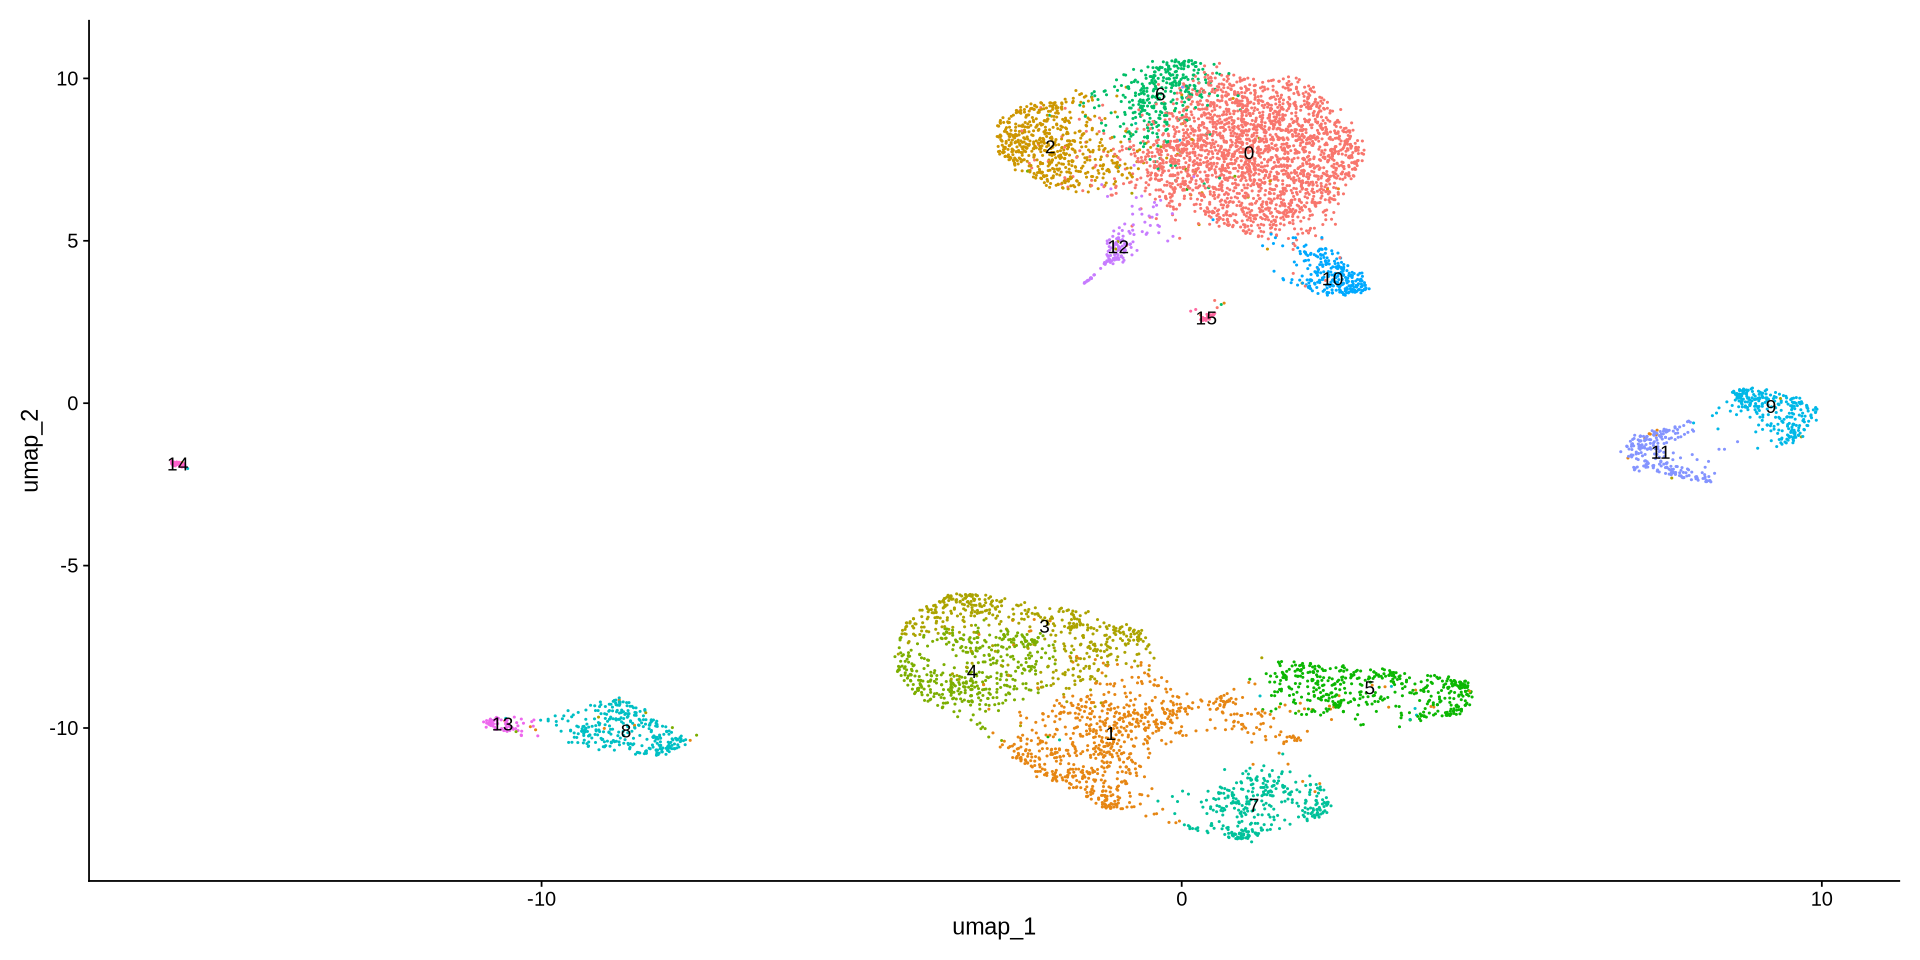

In [38]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, algorithm = 3)

DimPlot(object = pbmc, label = TRUE) + NoLegend()